# Predicting turnout

In [17]:
%load_ext black

# Libaries that may or may not be useful
import matplotlib
import numpy as np
from pathlib import Path
import pandas as pd

# import seaborn as sns
from sklearn import (
    ensemble,
    linear_model,
    metrics,
    model_selection,
    neural_network,
    tree,
)
from lightgbm import LGBMRegressor

import maven

# Config
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
DATA_DIR = Path("data/")

The black module is not an IPython extension.


In [18]:
df = pd.read_csv(
    "data/general-election/UK/2015/model/processed/general_election-uk-2015-model.csv"
)
df.head(15)

,Press Association Reference,Constituency Name,Region,Electorate,Votes,party,votes_last,pc_last,win_last,polls_now,swing_now,swing_forecast_pc,swing_forecast_win,actual_win_now,actual_pc_now,con,grn,lab,ld,ukip,Region_East Midlands,Region_Eastern,Region_London,Region_North East,Region_North West,Region_Northern Ireland,Region_Scotland,Region_South East,Region_South West,Region_Wales,Region_West Midlands,Region_Yorkshire and the Humber,won_here_last,turnout
0,1.0,Aberavon,Wales,50838.0,30958,con,4411.0,0.142483,lab,0.338182,-0.062021,0.133646,lab,lab,0.118707,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.608954
1,1.0,Aberavon,Wales,50838.0,30958,lab,16073.0,0.519187,lab,0.337273,0.163400,0.604022,lab,lab,0.489040,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.608954
2,1.0,Aberavon,Wales,50838.0,30958,ld,5034.0,0.162607,lab,0.090000,-0.609159,0.063554,lab,lab,0.044317,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.608954
3,1.0,Aberavon,Wales,50838.0,30958,ukip,489.0,0.015796,lab,0.127273,3.109344,0.064910,lab,lab,0.157694,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.608954
4,1.0,Aberavon,Wales,50838.0,30958,grn,0.0,0.000000,lab,0.048182,4.008203,0.000000,lab,lab,0.022555,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.608954
5,2.0,Aberconwy,Wales,44593.0,29966,con,10734.0,0.358206,con,0.338182,-0.062021,0.335990,con,con,0.415052,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.671989
6,2.0,Aberconwy,Wales,44593.0,29966,lab,7336.0,0.244811,con,0.337273,0.163400,0.284813,con,con,0.282407,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.671989
7,2.0,Aberconwy,Wales,44593.0,29966,ld,5786.0,0.193085,con,0.090000,-0.609159,0.075466,con,con,0.046139,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.671989
8,2.0,Aberconwy,Wales,44593.0,29966,ukip,632.0,0.021091,con,0.127273,3.109344,0.086668,con,con,0.114999,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.671989
9,2.0,Aberconwy,Wales,44593.0,29966,grn,0.0,0.000000,con,0.048182,4.008203,0.000000,con,con,0.024114,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.671989


In [19]:
census = pd.read_csv("census_file.csv")

In [20]:
df = df.merge(
    census[
        [
            "c11Male",
            "c11EthnicityWhite",
            "c11EthnicityMixed",
            "c11EthnicityAsian",
            "c11EthnicityBlack",
            "c11EthnicityOther",
            "c11EthnicityWhiteBritish",
            "c11EthnicityWhiteIrish",
            "c11EthnicityWhiteTraveller",
            "c11EthnicityWhiteOther",
            "c11EthnicityMixedCaribbean",
            "c11EthnicityMixedAfrican",
            "c11EthnicityMixedAsian",
            "c11EthnicityMixedOther",
            "c11EthnicityIndian",
            "c11EthnicityPakistani",
            "c11EthnicityBangladeshi",
            "c11EthnicityChinese",
            "c11EthnicityOtherAsian",
            "c11EthnicityBlackAfrican",
            "c11EthnicityBlackCaribbean",
            "c11EthnicityBlackOther",
            "c11EthnicityArab",
            "c11EthnicityAnyOther",
            "c11Degree",
            "c11Age0to4",
            "c11Age5to7",
            "c11Age8to9",
            "c11Age10to14",
            "c11Age15",
            "c11Age16to17",
            "c11Age18to19",
            "c11Age20to24",
            "c11Age25to29",
            "c11Age30to44",
            "c11Age45to59",
            "c11Age60to64",
            "c11Age65to74",
            "c11Age75to84",
            "c11Age85to89",
            "c11Age90plus",
            "constituency_name",
        ]
    ].rename({"constituency_name": "Constituency Name"}, axis=1),
    on="Constituency Name",
)

In [21]:
df.columns

Index(['Press Association Reference', 'Constituency Name', 'Region',
       'Electorate', 'Votes', 'party', 'votes_last', 'pc_last', 'win_last',
       'polls_now', 'swing_now', 'swing_forecast_pc', 'swing_forecast_win',
       'actual_win_now', 'actual_pc_now', 'con', 'grn', 'lab', 'ld', 'ukip',
       'Region_East Midlands', 'Region_Eastern', 'Region_London',
       'Region_North East', 'Region_North West', 'Region_Northern Ireland',
       'Region_Scotland', 'Region_South East', 'Region_South West',
       'Region_Wales', 'Region_West Midlands',
       'Region_Yorkshire and the Humber', 'won_here_last', 'turnout',
       'c11Male', 'c11EthnicityWhite', 'c11EthnicityMixed',
       'c11EthnicityAsian', 'c11EthnicityBlack', 'c11EthnicityOther',
       'c11EthnicityWhiteBritish', 'c11EthnicityWhiteIrish',
       'c11EthnicityWhiteTraveller', 'c11EthnicityWhiteOther',
       'c11EthnicityMixedCaribbean', 'c11EthnicityMixedAfrican',
       'c11EthnicityMixedAsian', 'c11EthnicityMixedOther

In [22]:
USELESS = [
    "Press Association Reference",
    "con",
    "grn",
    "lab",
    "ld",
    "ukip",
    "Region_East Midlands",
    "Region_Eastern",
    "Region_London",
    "Region_North East",
    "Region_North West",
    "Region_Northern Ireland",
    "Region_Scotland",
    "Region_South East",
    "Region_South West",
    "Region_Wales",
    "Region_West Midlands",
    "Region_Yorkshire and the Humber",
    "won_here_last",
]
CATEGORICAL = [
    "Constituency Name",
    "Region",
    "party",
    "win_last",
    "swing_forecast_win",
    "actual_win_now",
    "actual_pc_now",
]

df[CATEGORICAL] = df[CATEGORICAL].astype("category")

In [23]:
df.drop(USELESS, axis=1, inplace=True)

In [24]:
df.head(10)

,Constituency Name,Region,Electorate,Votes,party,votes_last,pc_last,win_last,polls_now,swing_now,swing_forecast_pc,swing_forecast_win,actual_win_now,actual_pc_now,turnout,c11Male,c11EthnicityWhite,c11EthnicityMixed,c11EthnicityAsian,c11EthnicityBlack,c11EthnicityOther,c11EthnicityWhiteBritish,c11EthnicityWhiteIrish,c11EthnicityWhiteTraveller,c11EthnicityWhiteOther,c11EthnicityMixedCaribbean,c11EthnicityMixedAfrican,c11EthnicityMixedAsian,c11EthnicityMixedOther,c11EthnicityIndian,c11EthnicityPakistani,c11EthnicityBangladeshi,c11EthnicityChinese,c11EthnicityOtherAsian,c11EthnicityBlackAfrican,c11EthnicityBlackCaribbean,c11EthnicityBlackOther,c11EthnicityArab,c11EthnicityAnyOther,c11Degree,c11Age0to4,c11Age5to7,c11Age8to9,c11Age10to14,c11Age15,c11Age16to17,c11Age18to19,c11Age20to24,c11Age25to29,c11Age30to44,c11Age45to59,c11Age60to64,c11Age65to74,c11Age75to84,c11Age85to89,c11Age90plus
0,Aberavon,Wales,50838.0,30958,con,4411.0,0.142483,lab,0.338182,-0.062021,0.133646,lab,lab,0.118707,0.608954,48.766879,97.586681,0.733371,1.250510,0.296372,0.133065,96.322562,0.371978,0.133065,0.759076,0.332663,0.054436,0.190525,0.155747,0.234376,0.117944,0.320566,0.237400,0.340223,0.108872,0.170868,0.016633,0.061996,0.071069,8.289718,5.511621,3.161810,2.000514,5.750533,1.236901,2.683985,2.271181,6.010615,6.539852,19.132657,20.889722,6.494488,9.535330,6.270697,1.673900,0.836194
1,Aberavon,Wales,50838.0,30958,lab,16073.0,0.519187,lab,0.337273,0.163400,0.604022,lab,lab,0.489040,0.608954,48.766879,97.586681,0.733371,1.250510,0.296372,0.133065,96.322562,0.371978,0.133065,0.759076,0.332663,0.054436,0.190525,0.155747,0.234376,0.117944,0.320566,0.237400,0.340223,0.108872,0.170868,0.016633,0.061996,0.071069,8.289718,5.511621,3.161810,2.000514,5.750533,1.236901,2.683985,2.271181,6.010615,6.539852,19.132657,20.889722,6.494488,9.535330,6.270697,1.673900,0.836194
2,Aberavon,Wales,50838.0,30958,ld,5034.0,0.162607,lab,0.090000,-0.609159,0.063554,lab,lab,0.044317,0.608954,48.766879,97.586681,0.733371,1.250510,0.296372,0.133065,96.322562,0.371978,0.133065,0.759076,0.332663,0.054436,0.190525,0.155747,0.234376,0.117944,0.320566,0.237400,0.340223,0.108872,0.170868,0.016633,0.061996,0.071069,8.289718,5.511621,3.161810,2.000514,5.750533,1.236901,2.683985,2.271181,6.010615,6.539852,19.132657,20.889722,6.494488,9.535330,6.270697,1.673900,0.836194
3,Aberavon,Wales,50838.0,30958,ukip,489.0,0.015796,lab,0.127273,3.109344,0.064910,lab,lab,0.157694,0.608954,48.766879,97.586681,0.733371,1.250510,0.296372,0.133065,96.322562,0.371978,0.133065,0.759076,0.332663,0.054436,0.190525,0.155747,0.234376,0.117944,0.320566,0.237400,0.340223,0.108872,0.170868,0.016633,0.061996,0.071069,8.289718,5.511621,3.161810,2.000514,5.750533,1.236901,2.683985,2.271181,6.010615,6.539852,19.132657,20.889722,6.494488,9.535330,6.270697,1.673900,0.836194
4,Aberavon,Wales,50838.0,30958,grn,0.0,0.000000,lab,0.048182,4.008203,0.000000,lab,lab,0.022555,0.608954,48.766879,97.586681,0.733371,1.250510,0.296372,0.133065,96.322562,0.371978,0.133065,0.759076,0.332663,0.054436,0.190525,0.155747,0.234376,0.117944,0.320566,0.237400,0.340223,0.108872,0.170868,0.016633,0.061996,0.071069,8.289718,5.511621,3.161810,2.000514,5.750533,1.236901,2.683985,2.271181,6.010615,6.539852,19.132657,20.889722,6.494488,9.535330,6.270697,1.673900,0.836194
5,Aberconwy,Wales,44593.0,29966,con,10734.0,0.358206,con,0.338182,-0.062021,0.335990,con,con,0.415052,0.671989,48.334663,97.837455,0.840202,0.879199,0.171940,0.271204,95.175042,0.758663,0.044314,1.859435,0.283613,0.143579,0.226890,0.186121,0.200301,0.060268,0.088629,0.276522,0.253479,0.101037,0.028361,0.042542,0.148897,0.122308,14.152319,4.956129,2.761677,1.777896,5.475494,1.123815,2.451476,2.148365,5.138704,4.729239,16.867854,20.485686,7.861384,12.005672,8.685633,2.338031,1.192945
6,Aberconwy,Wales,44593.0,29966,lab,7336.0,0.244811,con,0.337273,0.163400,0.284813,con,con,0.282407,0.671989,48.334663,97.837455,0.840202,0.879199,0.171940,0.271204,95.175042,0.758663,0.044314,1.859435,0.283613

In [25]:
model = LGBMRegressor()

In [36]:
from sklearn.model_selection import train_test_split

lgbm = LGBMRegressor(n_estimators=10000, learning_rate=0.4)

train_data, val_data, train_target, val_target = train_test_split(
    df.drop(["turnout", "Votes"], axis=1), df.turnout
)
lgbm.fit(
    train_data,
    train_target,
    eval_set=[(train_data, train_target), (val_data, val_target)],
    eval_metric="mae",
    early_stopping_rounds=100,
    verbose=100,
)

Training until validation scores don't improve for 100 rounds.
[100]	training's l1: 8.99793e-05	training's l2: 1.66706e-07	valid_1's l1: 0.000220331	valid_1's l2: 3.21783e-07
[200]	training's l1: 2.6881e-05	training's l2: 1.22084e-08	valid_1's l1: 0.000152654	valid_1's l2: 9.13443e-08
[300]	training's l1: 9.43874e-06	training's l2: 1.29937e-09	valid_1's l1: 0.000143831	valid_1's l2: 8.25508e-08
[400]	training's l1: 3.19822e-06	training's l2: 2.10882e-10	valid_1's l1: 0.000141333	valid_1's l2: 8.14845e-08
[500]	training's l1: 1.40388e-06	training's l2: 5.76588e-11	valid_1's l1: 0.00014048	valid_1's l2: 8.14676e-08
Early stopping, best iteration is:
[463]	training's l1: 1.94657e-06	training's l2: 8.28245e-11	valid_1's l1: 0.000140619	valid_1's l2: 8.12731e-08


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.4, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [37]:
val_data.shape

(467, 54)

In [38]:
model = LGBMRegressor(n_estimators=463)

In [39]:
# Some useful functions
def score_model(model, X, y, repeats=5):
    """Calculates a "5x5" (repeated 5-fold) cross-validated shuffled mean average error.
       Returns the mean across 5 (default) repeats."""
    mmae = []
    for i in range(repeats):
        mmae += [
            -np.mean(
                model_selection.cross_val_score(
                    model,
                    X=X,
                    y=y,
                    cv=model_selection.KFold(n_splits=5, shuffle=True),
                    scoring="neg_mean_absolute_error",
                )
            )
        ]
    return np.mean(mmae)


def score_features(model, features):
    """Helper function to run scoring function for a feature subset and using turnout.
       This equates to average turnout error per seat."""
    return score_model(model=model, X=df[features], y=df["turnout"])

In [40]:
# 0.3% average error per seat
score_features(model=model, features=train_data.columns)

0.00024184127633991183

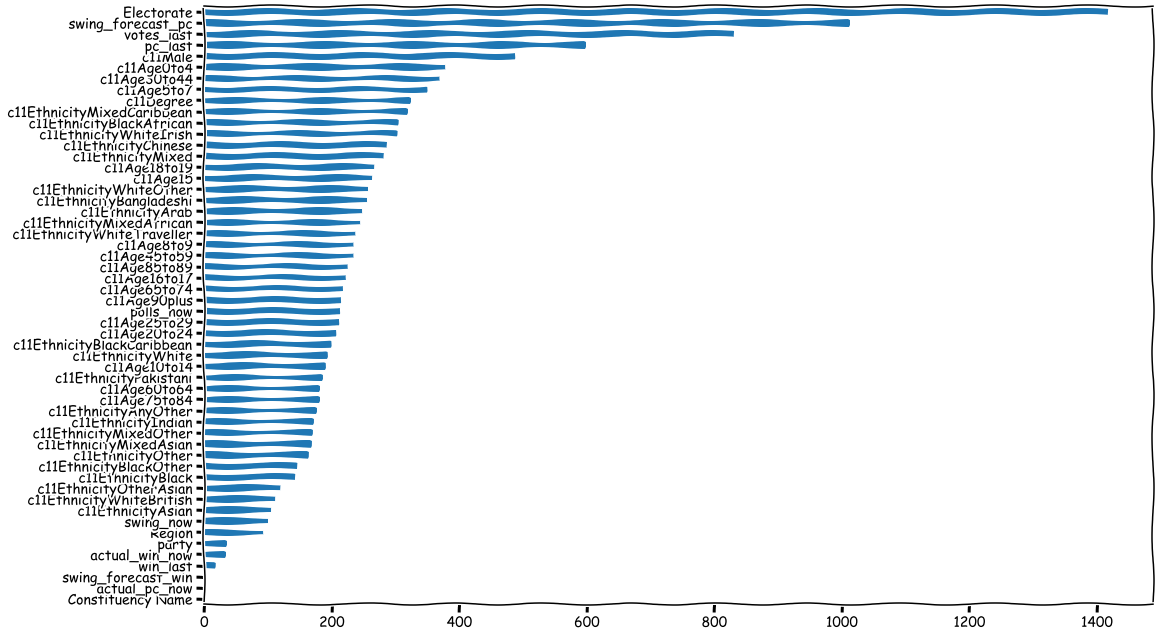

In [41]:
import matplotlib.pyplot as plt

plt.xkcd()

pd.Series(lgbm.feature_importances_, index=train_data.columns).sort_values().plot(
    kind="barh", figsize=(17, 11)
)
plt.show()